In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, models

import os

import shutil 
from tqdm import tqdm
import time
import copy

In [20]:
!unzip -u "/content/plates.zip"

Archive:  /content/plates.zip
   creating: plates/
  inflating: plates/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/plates/
  inflating: __MACOSX/plates/._.DS_Store  
   creating: plates/test/
  inflating: plates/test/0071.jpg    
  inflating: plates/test/0717.jpg    
  inflating: plates/test/0703.jpg    
  inflating: plates/test/0065.jpg    
  inflating: plates/test/0059.jpg    
  inflating: plates/test/0515.jpg    
  inflating: plates/test/0273.jpg    
  inflating: plates/test/0267.jpg    
  inflating: plates/test/0501.jpg    
  inflating: plates/test/0529.jpg    
  inflating: plates/test/0298.jpg    
  inflating: plates/test/0461.jpg    
  inflating: plates/test/0307.jpg    
  inflating: plates/test/0313.jpg    
  inflating: plates/test/0475.jpg    
  inflating: plates/test/0449.jpg    
  inflating: plates/test/0105.jpg    
  inflating: plates/test/0663.jpg    
  inflating: plates/test/0677.jpg    
  inflating: plates/test/0111.jpg    
  inflating: plates/test/0139

In [21]:
data_root = '/content/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [22]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 2074.53it/s]


In [23]:
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
len(train_dataloader), len(train_dataset)

(5, 34)

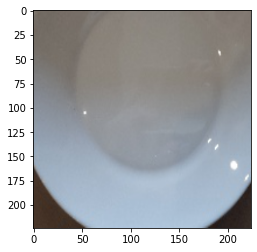

In [25]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

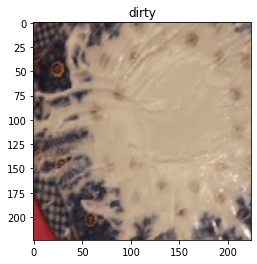

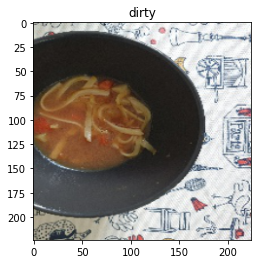

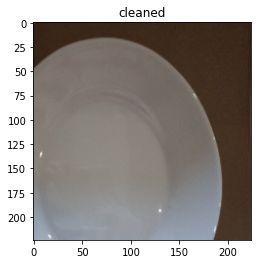

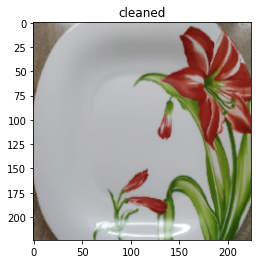

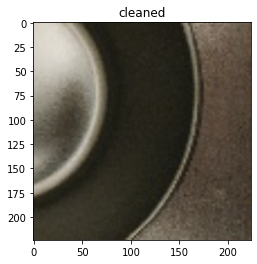

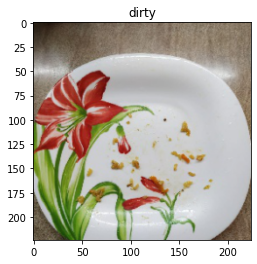

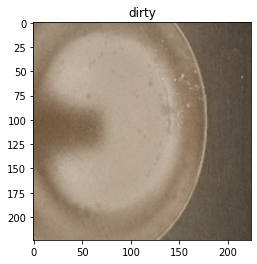

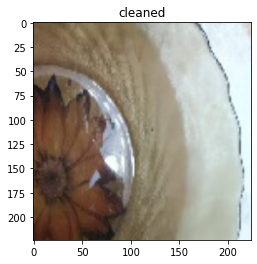

In [26]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [30]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [27]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [33]:
train_model(model, loss, optimizer, scheduler, num_epochs=30);

Epoch 0/29:


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

train Loss: 0.4754 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.4736 Acc: 0.6667
Epoch 1/29:



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

train Loss: 0.4639 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

val Loss: 0.4665 Acc: 0.6667
Epoch 2/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.4905 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.4643 Acc: 0.6667
Epoch 3/29:



100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

train Loss: 0.4109 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.4503 Acc: 0.6667
Epoch 4/29:



100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

train Loss: 0.4670 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

val Loss: 0.4484 Acc: 0.6667
Epoch 5/29:



100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

train Loss: 0.4476 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.4527 Acc: 0.6667
Epoch 6/29:



100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

train Loss: 0.5133 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.4537 Acc: 0.6667
Epoch 7/29:



100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

train Loss: 0.5879 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

val Loss: 0.4816 Acc: 0.6667
Epoch 8/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.5596 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.4821 Acc: 0.6667
Epoch 9/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.4932 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.4604 Acc: 0.6667
Epoch 10/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.4439 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.4677 Acc: 0.6667
Epoch 11/29:



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

train Loss: 0.4800 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.4581 Acc: 0.6667
Epoch 12/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.5391 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.4669 Acc: 0.8333
Epoch 13/29:



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

train Loss: 0.5223 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.4771 Acc: 0.6667
Epoch 14/29:



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

train Loss: 0.4857 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.4737 Acc: 0.6667
Epoch 15/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.5353 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.4730 Acc: 0.6667
Epoch 16/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.5452 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.4541 Acc: 0.6667
Epoch 17/29:



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

train Loss: 0.5358 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.4509 Acc: 0.6667
Epoch 18/29:



100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

train Loss: 0.5528 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.4632 Acc: 0.6667
Epoch 19/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.4730 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.4812 Acc: 0.6667
Epoch 20/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.4567 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.4552 Acc: 0.6667
Epoch 21/29:



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

train Loss: 0.4656 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.4843 Acc: 0.6667
Epoch 22/29:



100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

train Loss: 0.4756 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.4827 Acc: 0.6667
Epoch 23/29:



100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

train Loss: 0.4913 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.4463 Acc: 0.6667
Epoch 24/29:



100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

train Loss: 0.5119 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.4505 Acc: 0.8333
Epoch 25/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.4681 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.4476 Acc: 0.8333
Epoch 26/29:



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

train Loss: 0.5350 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.4519 Acc: 0.6667
Epoch 27/29:



100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

train Loss: 0.5309 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.4598 Acc: 0.6667
Epoch 28/29:



100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

train Loss: 0.5707 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.4689 Acc: 0.6667
Epoch 29/29:



100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

train Loss: 0.4791 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

val Loss: 0.4484 Acc: 0.6667


In [34]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [36]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/content/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [37]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [01:09<00:00,  1.33it/s]


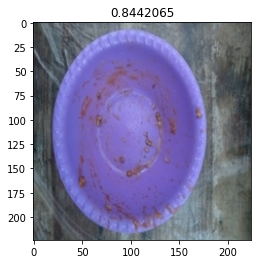

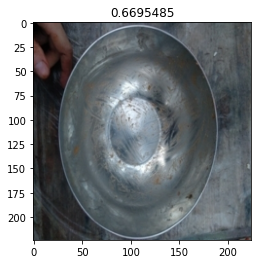

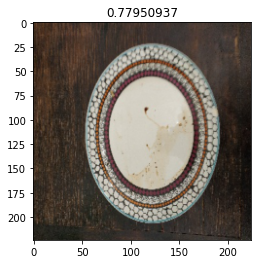

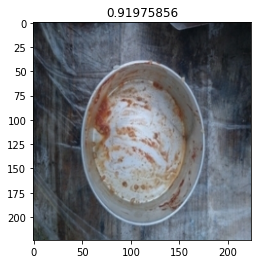

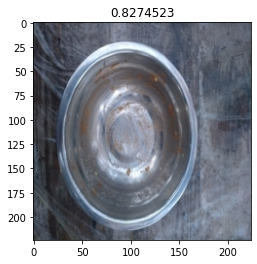

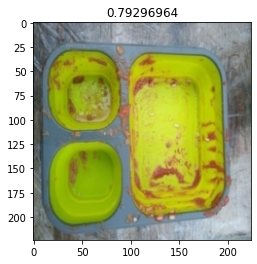

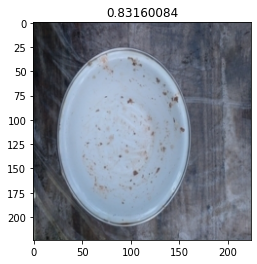

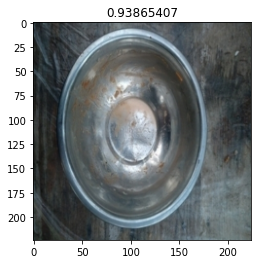

In [38]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [44]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [54]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
#submission_df['id'] = submission_df['id'].str.replace('/сontent/test/unknown/', '')
#submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
#submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,0.844207
0001,0.669549
0002,0.779509
0003,0.919759
0004,0.827452
0005,0.792970


In [46]:
submission_df.to_csv('submission.csv')